In [2]:
import cv2
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [3]:
def image_arrs(paths, im_arr):
    for path in paths:
        #read images, may need to change filepath
        fp = os.path.join('GTSRB Data', 'train.csv')
        image = cv2.imread('GTSRB Data/'+path)
        image_from_array = Image.fromarray(image, 'RGB')
        #resize all images to 30x30
        size_image = image_from_array.resize((30, 30))
        #convert images to array
        image_arr = np.array(size_image.getdata(),
                        np.uint8).reshape(size_image.size[1], size_image.size[0], 3)
        im_arr.append(image_arr.flatten())
    return im_arr

In [4]:
#this may take a minute
fp = os.path.join('GTSRB Data', 'train.csv')
df = pd.read_csv(fp)
#all filepaths for class 1 and 2
paths1 = df[(df['ClassId']==1)]['Path'].values
paths2 = df[(df['ClassId']==2)]['Path'].values

class1_arrs = []
class1_arrs = image_arrs(paths1, class1_arrs)

class2_arrs = []
class2_arrs = image_arrs(paths2, class2_arrs)

True

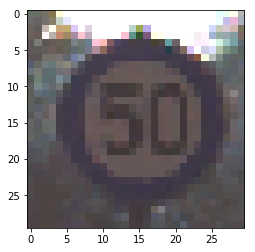

In [5]:
#class 1 images
plt.imshow(class1_arrs[0].reshape(30, 30, 3))

#class 2 images
plt.imshow(class2_arrs[50].reshape(30, 30, 3))


#concat data and labels 
X = class1_arrs + class2_arrs
y = len(class1_arrs)*[0] + len(class2_arrs)*[1]

#check data is the same length as labels
len(X)==len(y)


In [6]:
mean = np.mean(X)
std = np.std(X)
standardized_X = (X - mean) / std

mean = np.mean(y)
std = np.std(y)
standardized_y = (y - mean) / std

In [7]:
test_X = torch.from_numpy(np.array(X)).float()
test_y = torch.from_numpy(np.array(y)).float()

In [8]:
class LogisticModel(torch.nn.Module):
    def __init__(self):
        super(LogisticModel, self).__init__()
        self.linear = torch.nn.Linear(2700, 1)
        
    def forward(self, x_val):
        y_pred = torch.sigmoid(self.linear(x_val))
        return y_pred

In [9]:
model = LogisticModel()

def train_model(model, inp, outp):
    
    losses = []
    
    criterion = torch.nn.BCELoss(reduction='mean')
    #first param take param of model (x_data) learning rate is 0.0001
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    
    for instance in range(2000):
        y_pred = model(inp)

        loss = criterion(y_pred, outp)
        losses.append(loss.data)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return losses

In [11]:
model(test_X)

test_losses = train_model(model, test_X, test_y)

/Users/jasrajjohl/anaconda3/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([4470])) that is different to the input size (torch.Size([4470, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


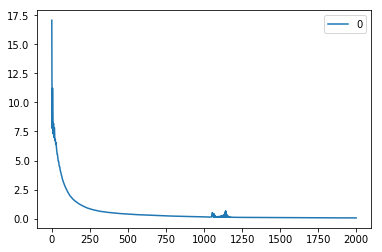

In [124]:
pd.DataFrame(test_losses).plot(kind='line')

In [125]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train = torch.from_numpy(np.array(X_train)).float()
y_train = torch.from_numpy(np.array(y_train)).float()
X_test = torch.from_numpy(np.array(X_test)).float()
y_test = torch.from_numpy(np.array(y_test)).float()

start_model = LogisticModel()

In [126]:
real_losses = train_model(start_model, X_train, y_train)

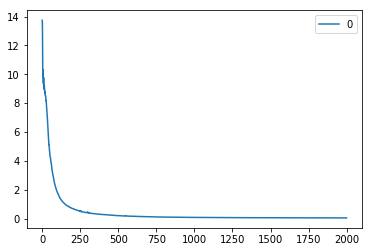

In [127]:
pd.DataFrame(real_losses).plot(kind='line')

In [128]:
def get_preds(model, x_val):
    check_x = []
    predictions = start_model(x_val)
    
    for i in predictions:
        check_x.append(int(i))
        
    return check_x

x_preds = get_preds(train_model, X_train)
x_real = get_preds(train_model, X_test)

In [129]:
accuracy_score(x_preds, y_train)

0.7273489932885906

In [130]:
accuracy_score(x_real, y_test)

0.7114093959731543

In [144]:
#train SVM mode
i_model = SVC()
i_model.fit(X_train, y_train)

#accuracy on train
i_model.score(X_train, y_train)



/Users/jasrajjohl/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


1.0